Starting quantum-to-classical gravitational field simulation with extended round-trip transitions...
Random seed set to 98331050
Initial conditions saved to initial_conditions.json
Q->C (forward): Layer 2 added at t=33.34
C->Q (forward): Layer 2 removed at t=33.34
Q->C (forward): Layer 3 added at t=66.68
C->Q (forward): Layer 1 removed at t=66.68
Q->C (backward): Layer 2 removed at t=133.34
C->Q (backward): Layer 2 added at t=133.34
Q->C (backward): Layer 1 removed at t=166.68
C->Q (backward): Layer 3 added at t=166.68
Data saved to bidirectional_evolution.csv

Summary plots saved to convergence_analysis.png


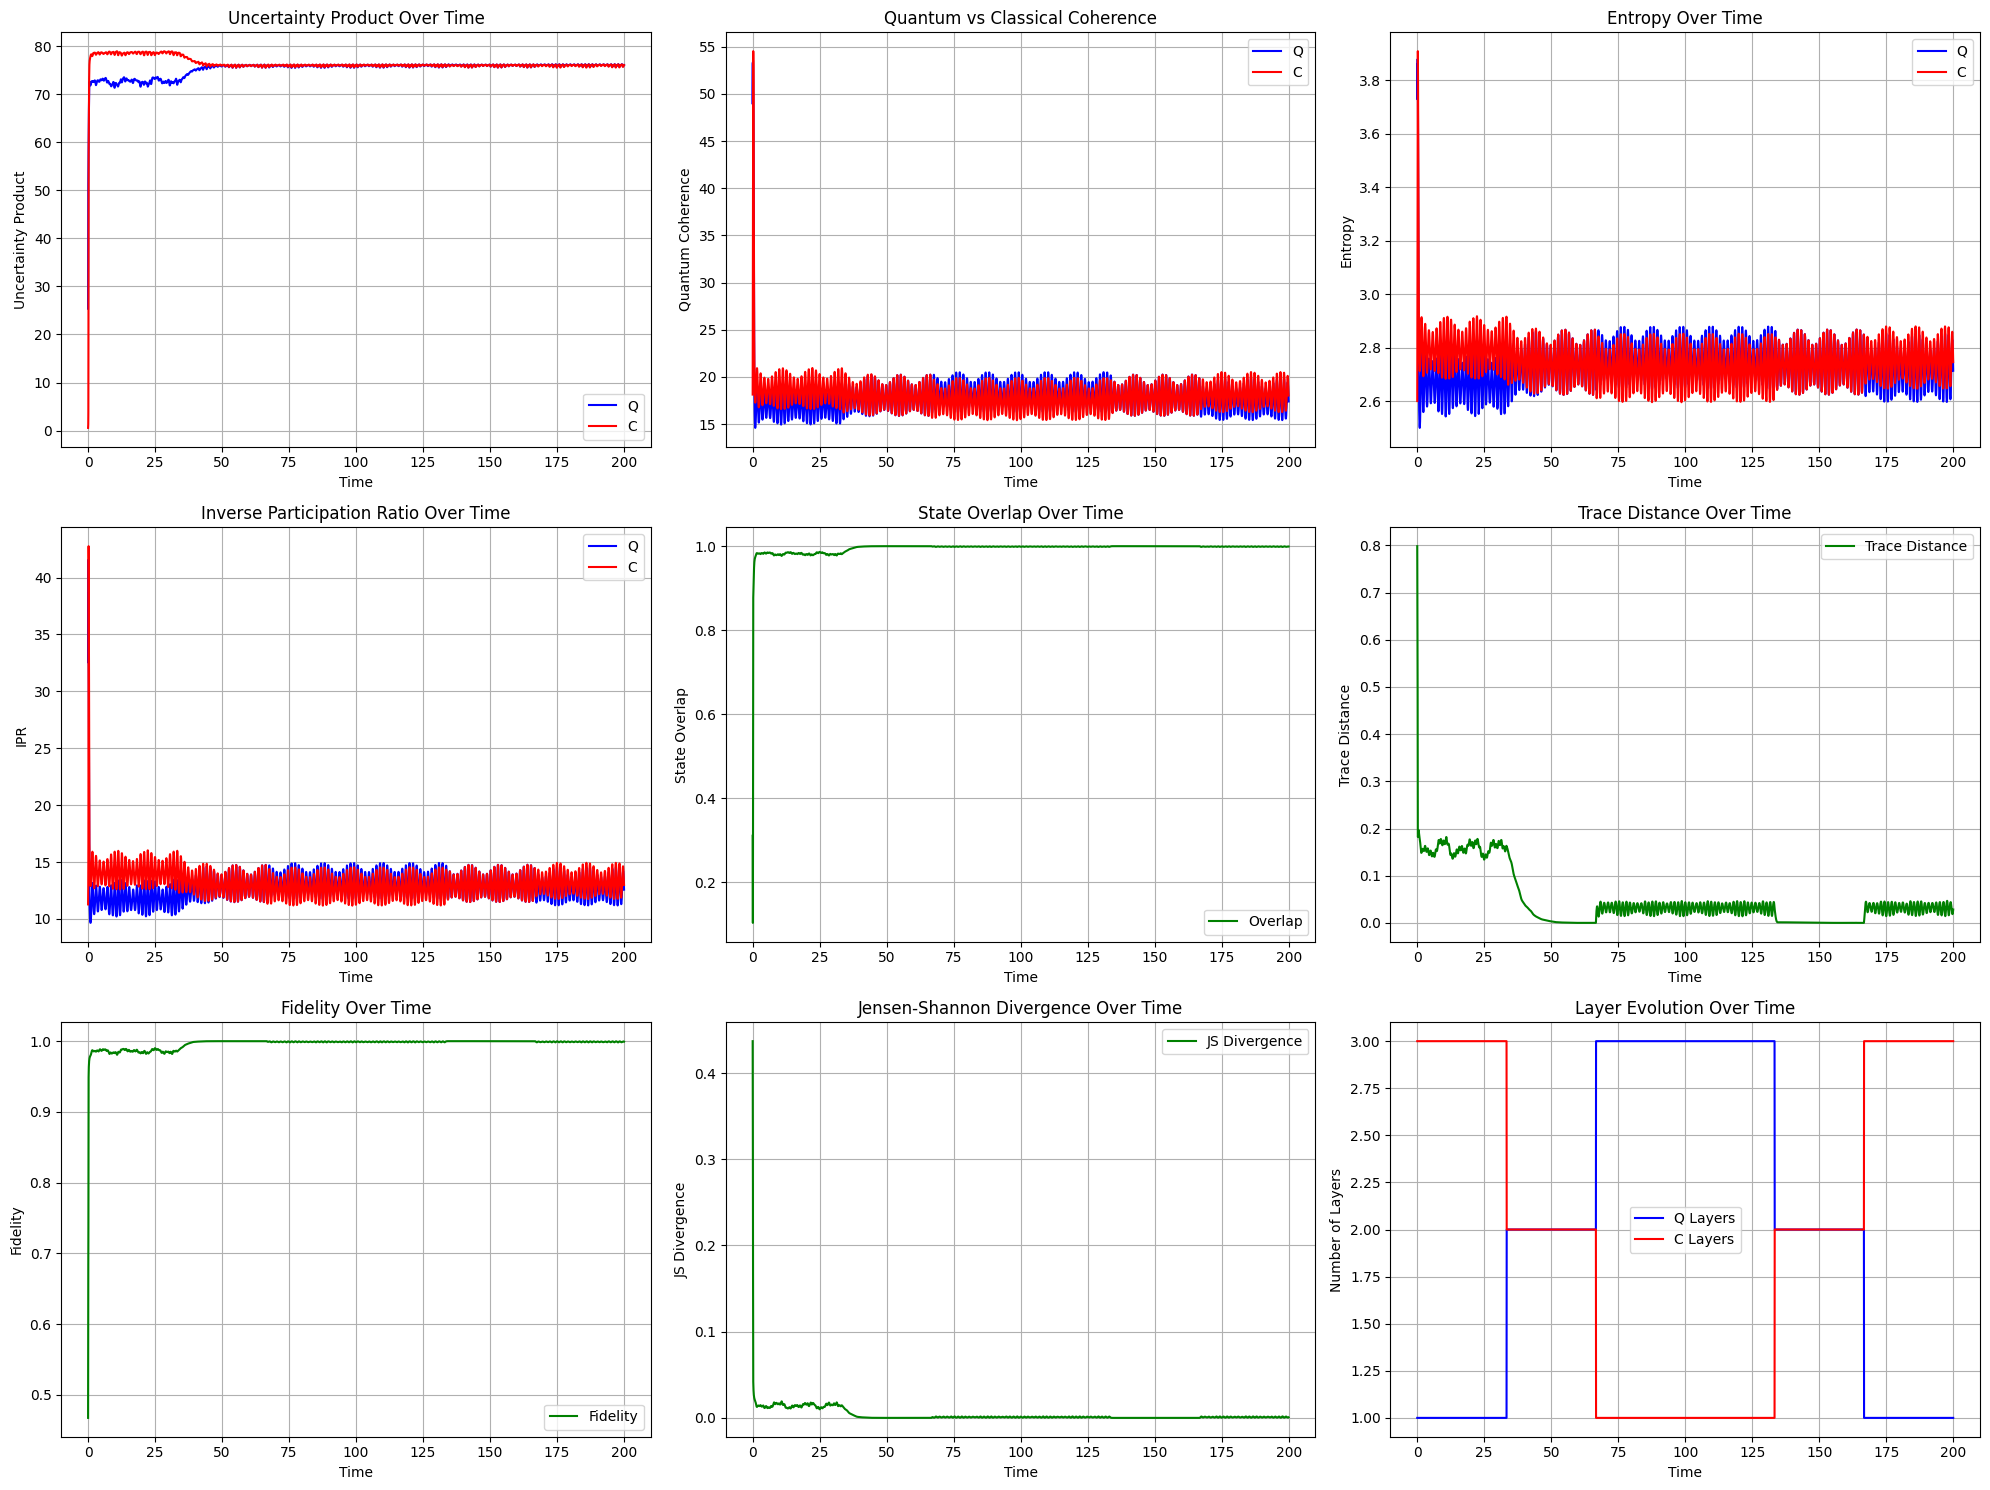

Density analysis plots saved to density_analysis.png


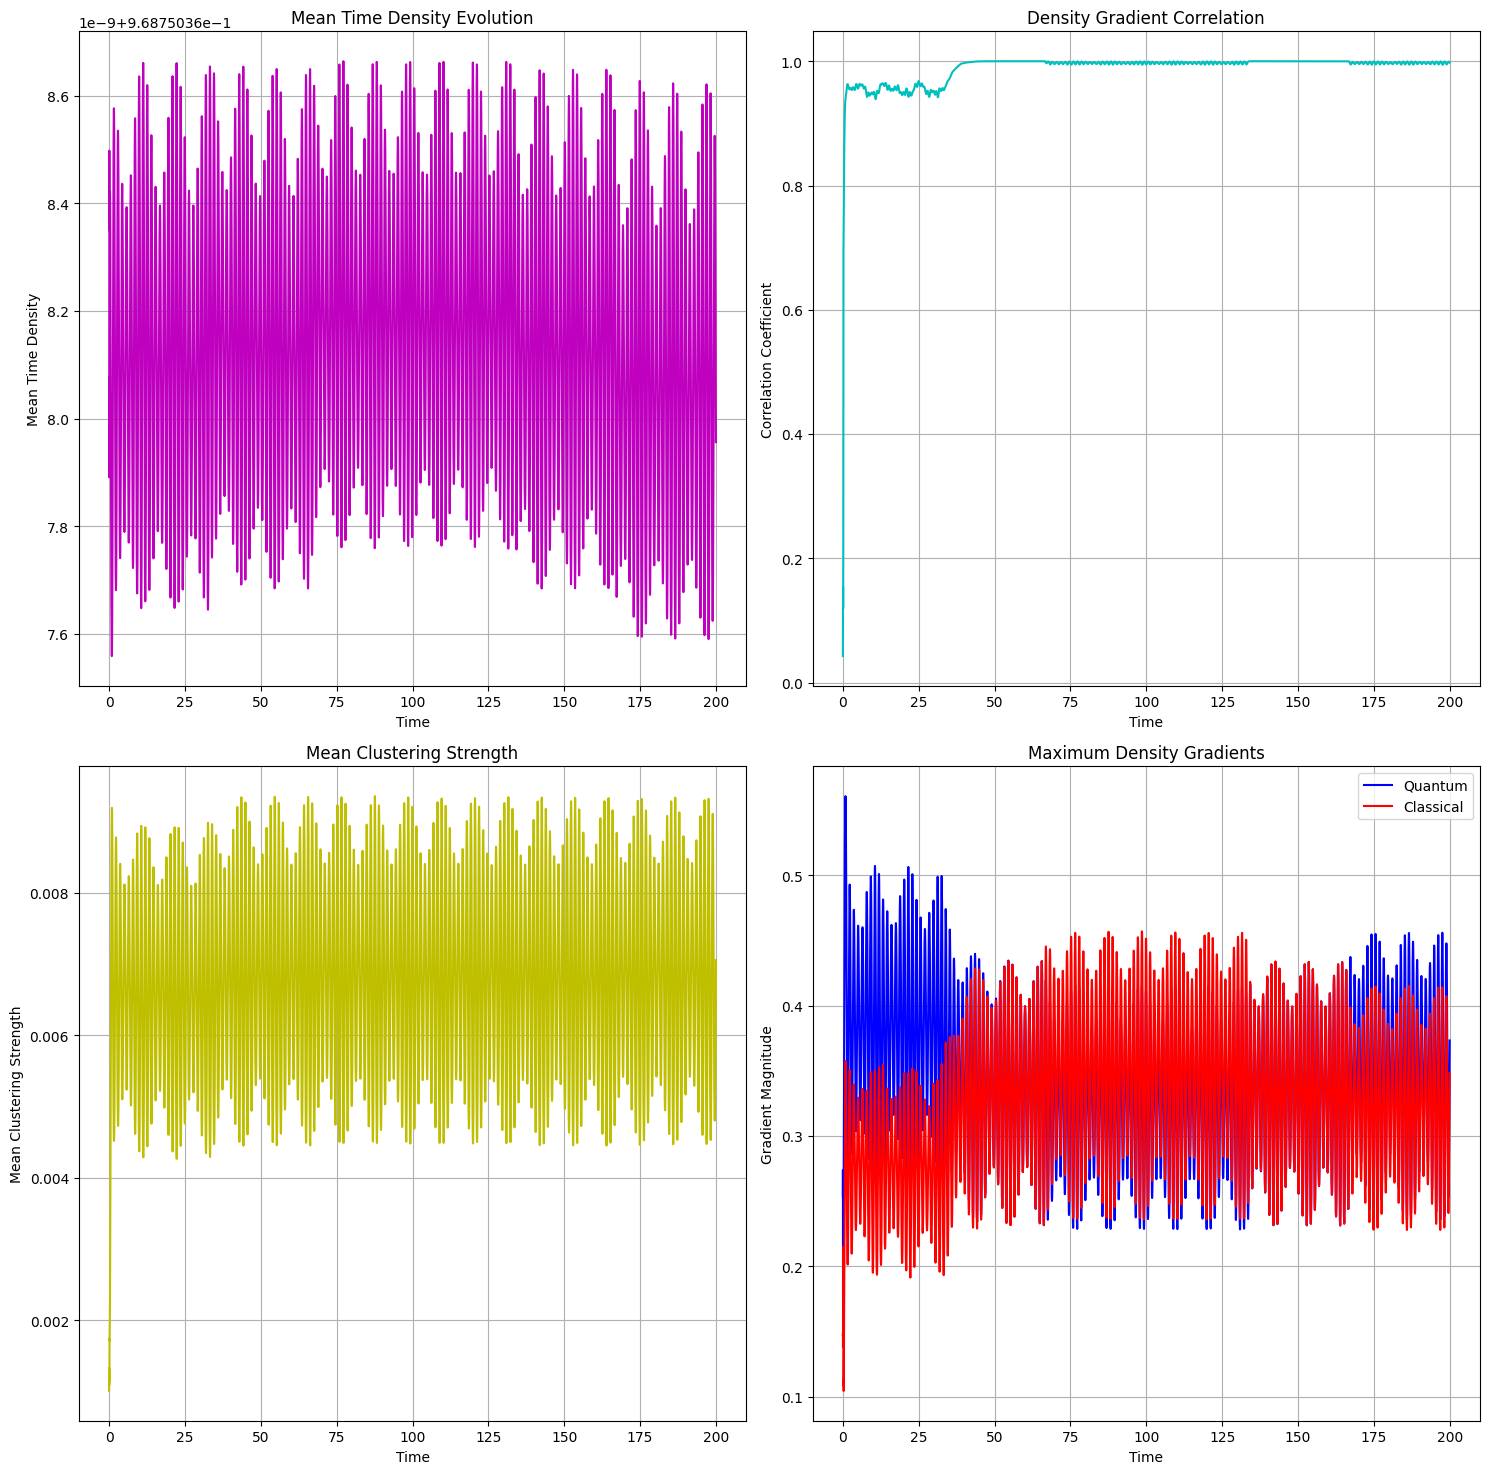

Plots saved to convergence_analysis.png and density_analysis.png

Found 144 strong resonance points:
Time: 1.58, Overlap: 0.984
Time: 2.50, Overlap: 0.983
Time: 3.40, Overlap: 0.984
Time: 4.46, Overlap: 0.985
Time: 5.50, Overlap: 0.985
Time: 6.36, Overlap: 0.985
Time: 7.32, Overlap: 0.983
Time: 8.38, Overlap: 0.980
Time: 9.40, Overlap: 0.981
Time: 10.22, Overlap: 0.981
Time: 11.38, Overlap: 0.981
Time: 12.36, Overlap: 0.985
Time: 13.14, Overlap: 0.986
Time: 14.14, Overlap: 0.986
Time: 15.18, Overlap: 0.984
Time: 16.22, Overlap: 0.983
Time: 17.16, Overlap: 0.984
Time: 18.14, Overlap: 0.984
Time: 19.14, Overlap: 0.981
Time: 20.04, Overlap: 0.981
Time: 21.04, Overlap: 0.983
Time: 22.04, Overlap: 0.980
Time: 23.16, Overlap: 0.982
Time: 23.96, Overlap: 0.985
Time: 24.98, Overlap: 0.986
Time: 25.98, Overlap: 0.985
Time: 26.78, Overlap: 0.984
Time: 27.88, Overlap: 0.981
Time: 28.98, Overlap: 0.982
Time: 29.88, Overlap: 0.981
Time: 30.82, Overlap: 0.981
Time: 31.86, Overlap: 0.982
Time: 32.84,

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import expm
from scipy.stats import entropy
from scipy.signal import find_peaks
import random
from scipy.interpolate import interp1d
import json
import os
from dataclasses import dataclass, asdict

##############################################################
# EXTENDED CODE WITH REAL SOLAR DATA (REPLACING PLACEHOLDER)
##############################################################
#
# This code implements the EchoKey-EFECGSC framework as described
# in the corresponding LaTeX paper. It models the quantum-to-classical
# gravitational transition by simulating graviton-like excitations
# clustering into solar-scale gravity cavities and their subsequent
# reverse transition back to quantum states.
#
# The framework integrates principles of synergy, fractality, recursion,
# and adaptive coupling to achieve a unified theory that bridges quantum
# gravity and classical general relativity.

############################
# Loading Real Solar Metric Data
############################

def load_solar_metric_data(dim, x_min, x_max, metric_file='solar_metric_data.npz'):
    """
    Load gravitational metric components from a precomputed solar model.
    
    Corresponds to:
    - "Data Generation from Solar Models" section in the paper.
    - "Incorporation of Tolman–Oppenheimer–Volkoff (TOV) Equations" subsection.
    
    Parameters:
    - dim (int): Number of spatial points in the simulation domain.
    - x_min (float): Minimum radial coordinate (meters).
    - x_max (float): Maximum radial coordinate (meters).
    - metric_file (str): Path to the .npz file containing r, g00, g11 arrays.
    
    Returns:
    - x_array (np.ndarray): Interpolated radial coordinates.
    - g00_interp (np.ndarray): Interpolated time-time metric component.
    - g11_interp (np.ndarray): Interpolated radial-radial metric component.
    """
    data = np.load(metric_file)
    r_data = data['r']
    g00_data = data['g00']
    g11_data = data['g11']
    
    # Create the simulation spatial array based on the specified domain and resolution
    x_array = np.linspace(x_min, x_max, dim)
    
    # Interpolate g00 and g11 metric components onto the simulation grid
    g00_interp_func = interp1d(r_data, g00_data, kind='cubic', fill_value="extrapolate")
    g11_interp_func = interp1d(r_data, g11_data, kind='cubic', fill_value="extrapolate")
    
    g00_interp = g00_interp_func(x_array)
    g11_interp = g11_interp_func(x_array)
    
    return x_array, g00_interp, g11_interp

############################
# Utility and Model Functions
############################

def C_n(t, A, omega, n=1, phi=0.0):
    """
    Calculate the nth cyclic component of the fractal potential.
    
    Corresponds to:
    - "Fractal Potentials and Recursive Structures" subsection in the paper.
    
    Parameters:
    - t (float): Current time.
    - A (np.ndarray): Amplitudes for each cyclic component.
    - omega (np.ndarray): Angular frequencies for each cyclic component.
    - n (int): Index of the current cyclic component.
    - phi (float): Phase offset.
    
    Returns:
    - float: Value of the nth cyclic component at time t.
    """
    return A[n-1] * np.sin(omega[n-1] * t + phi)

def F_n(x, c=0.1):
    """
    Define the fractal generation function at scale n.
    
    Corresponds to:
    - "Fractal Potentials and Recursive Structures" subsection in the paper.
    
    Parameters:
    - x (float or np.ndarray): Spatial coordinate(s).
    - c (float): Constant scaling factor.
    
    Returns:
    - float or np.ndarray: Output of the fractal generation function.
    """
    return x**2 + c

def fractal_potential(t, x_array, current_layer, A, omega, recursion_depth=2):
    """
    Generate the fractal potential based on recursive cyclic components.
    
    Corresponds to:
    - "Fractal Potentials and Recursive Structures" subsection in the paper.
    
    Parameters:
    - t (float): Current time.
    - x_array (np.ndarray): Array of spatial coordinates.
    - current_layer (int): Current layer of graviton clustering.
    - A (np.ndarray): Amplitudes for each cyclic component.
    - omega (np.ndarray): Angular frequencies for each cyclic component.
    - recursion_depth (int): Depth of recursion for fractal generation.
    
    Returns:
    - np.ndarray: Complex fractal potential across spatial coordinates.
    """
    V = np.zeros_like(x_array, dtype=complex)
    c = 0.1 * current_layer  # Scaling factor based on current layer
    for depth in range(1, recursion_depth+1):
        c_val = C_n(t, A, omega, n=depth)
        f_val = F_n(c_val, c=c)
        V += f_val * (0.5**depth) * x_array**2  # Recursive scaling
    return V

def synergy_matrix(dim, synergy_strength):
    """
    Create a synergy matrix representing nonlinear coupling between graviton states.
    
    Corresponds to:
    - "Synergy Matrix and Adaptive Coupling" subsection in the paper.
    
    Parameters:
    - dim (int): Dimension of the matrix (number of graviton states).
    - synergy_strength (float): Strength of the synergy interaction.
    
    Returns:
    - np.ndarray: Synergy matrix of shape (dim, dim).
    """
    mat = np.zeros((dim, dim), dtype=complex)
    for i in range(dim):
        for j in range(i+1, dim):
            mat[i,j] = synergy_strength
            mat[j,i] = synergy_strength  # Ensure symmetry
    return mat

def position_dependent_refraction(x_array, layer, dim, g00, g11):
    """
    Calculate the position-dependent refraction index based on current layer and metric components.
    
    Corresponds to:
    - "Synergy Matrix and Adaptive Coupling" subsection in the paper.
    
    Parameters:
    - x_array (np.ndarray): Array of spatial coordinates.
    - layer (int): Current layer of graviton clustering.
    - dim (int): Dimension of the simulation.
    - g00 (np.ndarray): Interpolated g00 metric component.
    - g11 (np.ndarray): Interpolated g11 metric component.
    
    Returns:
    - np.ndarray: Refraction index across spatial coordinates.
    """
    # Define refraction index as a function of layer and metric components
    n_values = 1.0 + 0.5 * layer + 0.1 * layer * (g11 - 1.0)
    # Ensure the refraction index array matches the simulation dimension
    if len(n_values) != dim:
        n_values = np.interp(np.linspace(x_array[0], x_array[-1], dim), x_array, n_values)
    return n_values

def dispersive_kinetic(dim, mass, dx, layer):
    """
    Construct the kinetic energy operator with dispersion based on current layer.
    
    Corresponds to:
    - "Synergy Matrix and Adaptive Coupling" subsection in the paper.
    
    Parameters:
    - dim (int): Dimension of the kinetic energy matrix.
    - mass (float): Mass parameter in the Hamiltonian.
    - dx (float): Spatial step size.
    - layer (int): Current layer of graviton clustering.
    
    Returns:
    - np.ndarray: Dispersive kinetic energy matrix.
    """
    T = np.zeros((dim, dim))
    dispersion_strength = 0.2 * layer  # Adjust dispersion based on layer
    
    for i in range(dim):
        T[i,i] = -2.0
        if i > 0:
            T[i,i-1] = 1.0 + dispersion_strength
        if i < dim-1:
            T[i,i+1] = 1.0 + dispersion_strength
    
    return -(1/(2*mass)) * T / (dx**2)

def compute_synergy_factor(psi, current_dim, synergy_alpha=0.5):
    """
    Calculate the synergy factor based on the overlap between adjacent graviton states.
    
    Corresponds to:
    - "Synergy Matrix and Adaptive Coupling" subsection in the paper.
    
    Parameters:
    - psi (np.ndarray): Wavefunction array.
    - current_dim (int): Current dimension of the simulation.
    - synergy_alpha (float): Scaling factor for synergy adjustment.
    
    Returns:
    - float: Synergy factor clamped between 0.8 and 1.2.
    """
    if len(psi) != current_dim:
        psi = psi[:current_dim]
    
    if current_dim < 2:
        return 1.0
    
    # Calculate correlation between adjacent graviton states
    corr = np.sum(np.abs(psi[:-1] * np.conjugate(psi[1:]))) / (current_dim - 1)
    synergy_factor = 1.0 + synergy_alpha * corr / 10.0
    return np.clip(synergy_factor, 0.8, 1.2)  # Ensure synergy factor remains within bounds

def compute_wavefunction_metrics(psi, x_array):
    """
    Compute various metrics of the wavefunction for analysis.
    
    Corresponds to:
    - "Results" section in the paper, specifically under "Key Observations."
    
    Parameters:
    - psi (np.ndarray): Wavefunction array.
    - x_array (np.ndarray): Array of spatial coordinates.
    
    Returns:
    - dict: Dictionary containing computed metrics.
    """
    rho = np.abs(psi)**2
    rho /= np.sum(rho)  # Normalize probability density
    
    # Calculate expectation values and uncertainties in position
    x_exp = np.sum(x_array * rho)
    x2_exp = np.sum(x_array**2 * rho)
    uncertainty_x = np.sqrt(abs(x2_exp - x_exp**2))
    
    # Fourier transform to momentum space
    psi_k = np.fft.fft(psi)
    k_array = 2*np.pi*np.fft.fftfreq(len(x_array), x_array[1]-x_array[0])
    rho_k = np.abs(psi_k)**2
    rho_k /= np.sum(rho_k)  # Normalize probability density in momentum space
    
    # Calculate expectation values and uncertainties in momentum
    k_exp = np.sum(k_array * rho_k)
    k2_exp = np.sum(k_array**2 * rho_k)
    uncertainty_k = np.sqrt(abs(k2_exp - k_exp**2))
    
    uncertainty_product = uncertainty_x * uncertainty_k  # Uncertainty principle
    
    # Calculate coherence, entropy, and inverse participation ratio (IPR)
    density_matrix = np.outer(psi, np.conjugate(psi))
    coherence = np.sum(np.abs(density_matrix - np.diag(np.diag(density_matrix))))
    entropy_value = entropy(rho + 1e-10)  # Add small value to prevent log(0)
    ipr = 1.0 / np.sum(rho**2)  # Inverse participation ratio
    
    # Identify peaks in the probability density
    peaks, _ = find_peaks(rho)
    
    return {
        'uncertainty_x': uncertainty_x,
        'uncertainty_k': uncertainty_k,
        'uncertainty_product': uncertainty_product,
        'coherence': coherence,
        'entropy': entropy_value,
        'ipr': ipr,
        'num_peaks': len(peaks),
        'x_expectation': x_exp
    }

def compute_state_similarity(psi1, psi2):
    """
    Compute similarity metrics between quantum and classical states.
    
    Corresponds to:
    - "State Similarity" subsection in the paper.
    
    Parameters:
    - psi1 (np.ndarray): Quantum state wavefunction.
    - psi2 (np.ndarray): Classical state wavefunction.
    
    Returns:
    - dict: Dictionary containing similarity metrics.
    """
    rho1 = np.abs(psi1)**2
    rho2 = np.abs(psi2)**2
    
    rho1 /= np.sum(rho1)  # Normalize probability densities
    rho2 /= np.sum(rho2)
    
    # Calculate overlap between the two states
    overlap = np.abs(np.sum(np.conjugate(psi1) * psi2))
    
    # Calculate trace distance between the two density matrices
    trace_distance = 0.5 * np.sum(np.abs(rho1 - rho2))
    
    # Calculate fidelity between the two states
    fidelity = np.sum(np.sqrt(rho1 * rho2))
    
    # Calculate Jensen-Shannon divergence
    m = 0.5 * (rho1 + rho2)
    js_divergence = 0.5 * (entropy(rho1 + 1e-10, m + 1e-10) + entropy(rho2 + 1e-10, m + 1e-10))
    
    return {
        'overlap': overlap,
        'trace_distance': trace_distance,
        'fidelity': fidelity,
        'js_divergence': js_divergence
    }

# Define characteristic frequencies for resonant driving
frequencies = np.array([1.0, 1.618, 2.618, 4.236])

def resonant_driving(t):
    """
    Generate a resonant driving term based on predefined frequencies.
    
    Corresponds to:
    - "Fractal Potentials and Recursive Structures" subsection in the paper.
    
    Parameters:
    - t (float): Current time.
    
    Returns:
    - complex: Resonant driving term.
    """
    return np.sum([np.exp(1j * f * t) for f in frequencies]) / len(frequencies)

def adaptive_coupling(psi1, psi2, base=0.1):
    """
    Calculate the adaptive coupling strength based on overlap between states.
    
    Corresponds to:
    - "Synergy Matrix and Adaptive Coupling" subsection in the paper.
    
    Parameters:
    - psi1 (np.ndarray): Quantum state wavefunction.
    - psi2 (np.ndarray): Classical state wavefunction.
    - base (float): Base coupling strength.
    
    Returns:
    - float: Adaptive coupling strength.
    """
    overlap = np.abs(np.sum(np.conjugate(psi1) * psi2))
    return base * (1.0 + np.tanh(5 * overlap))

def phase_matching(psi1, psi2):
    """
    Compute phase matching term between quantum and classical states.
    
    Corresponds to:
    - "Synergy Matrix and Adaptive Coupling" subsection in the paper.
    
    Parameters:
    - psi1 (np.ndarray): Quantum state wavefunction.
    - psi2 (np.ndarray): Classical state wavefunction.
    
    Returns:
    - np.ndarray: Phase matching term.
    """
    phase_diff = np.angle(psi1) - np.angle(psi2)
    return np.exp(-1j * phase_diff)

############################
# Initial Conditions Handling
############################

def save_initial_conditions(filename, psi_q, psi_c, A, omega, seed):
    """
    Save initial conditions to a JSON file for reproducibility.
    
    Corresponds to:
    - "Initial Conditions Handling" subsection in the paper.
    
    Parameters:
    - filename (str): Path to save the initial conditions.
    - psi_q (np.ndarray): Initial quantum state wavefunction.
    - psi_c (np.ndarray): Initial classical state wavefunction.
    - A (np.ndarray): Amplitudes for cyclic components.
    - omega (np.ndarray): Angular frequencies for cyclic components.
    - seed (int): Random seed used for initialization.
    """
    initial_conditions = {
        'psi_q_real': psi_q.real.tolist(),
        'psi_q_imag': psi_q.imag.tolist(),
        'psi_c_real': psi_c.real.tolist(),
        'psi_c_imag': psi_c.imag.tolist(),
        'A': A.tolist(),
        'omega': omega.tolist(),
        'random_seed': seed
    }
    with open(filename, 'w') as f:
        json.dump(initial_conditions, f, indent=4)
    print(f"Initial conditions saved to {filename}")

def load_initial_conditions(filename):
    """
    Load initial conditions from a JSON file.
    
    Corresponds to:
    - "Initial Conditions Handling" subsection in the paper.
    
    Parameters:
    - filename (str): Path to the initial conditions file.
    
    Returns:
    - tuple: (psi_q, psi_c, A, omega, seed)
    """
    with open(filename, 'r') as f:
        initial_conditions = json.load(f)
    psi_q = np.array(initial_conditions['psi_q_real']) + 1j * np.array(initial_conditions['psi_q_imag'])
    psi_c = np.array(initial_conditions['psi_c_real']) + 1j * np.array(initial_conditions['psi_c_imag'])
    A = np.array(initial_conditions['A'])
    omega = np.array(initial_conditions['omega'])
    seed = initial_conditions.get('random_seed', None)
    return psi_q, psi_c, A, omega, seed

############################
# Main Evolution Function
############################

def evolve_bidirectional_system(config):
    """
    Simulate the bidirectional quantum-classical gravitational field evolution.
    
    Corresponds to:
    - Entire "Mathematical Model" and "Computational Implementation" sections in the paper.
    - "Layer Evolution" part of the "Results" section.
    
    Parameters:
    - config (Config): Configuration dataclass instance with simulation parameters.
    
    Returns:
    - pd.DataFrame: DataFrame containing recorded simulation metrics.
    - np.ndarray: Final quantum state wavefunction.
    - np.ndarray: Final classical state wavefunction.
    - np.ndarray: Array of spatial coordinates.
    """
    # Set random seed for reproducibility
    if config.random_seed is not None:
        np.random.seed(config.random_seed)
        random.seed(config.random_seed)
        print(f"Random seed set to {config.random_seed}")
    
    # Load gravitational metric components from solar model data
    x_array, g00, g11 = load_solar_metric_data(config.dim_mode, config.x_min, config.x_max, config.metric_file)
    dx = x_array[1] - x_array[0]  # Spatial step size
    
    # Initialize quantum and classical wavefunctions
    if config.load_initial_conditions and os.path.exists(config.initial_conditions_file):
        psi_q, psi_c, A, omega, loaded_seed = load_initial_conditions(config.initial_conditions_file)
        if config.random_seed is not None and loaded_seed != config.random_seed:
            print("Warning: Loaded initial conditions were generated with a different random seed.")
    else:
        # Random initialization for quantum state
        psi_q = np.random.rand(config.dim_mode) + 1j * np.random.rand(config.dim_mode)
        psi_q /= np.linalg.norm(psi_q)  # Normalize wavefunction
    
        # Initial classical state as a Gaussian-like distribution
        psi_c = np.exp(-x_array**2 / np.sqrt(np.mean(np.abs(g11))))
        psi_c /= np.linalg.norm(psi_c)  # Normalize wavefunction
    
        # Initialize amplitudes and frequencies for cyclic components
        A = np.random.rand(config.layers) * 2  # Random amplitudes for each layer
        omega = np.random.rand(config.layers) * 5  # Random frequencies
    
        # Save initial conditions for reproducibility
        save_initial_conditions(config.initial_conditions_file, psi_q, psi_c, A, omega, config.random_seed)
    
    # Define time array for simulation, doubling the total_time for forward and reverse transitions
    half_time = config.total_time / 2.0
    t_values = np.arange(0, config.total_time, config.dt)
    
    record = []  # List to store simulation data
    
    # Initialize simulation parameters
    q_dim = config.dim_mode
    c_dim = config.dim_mode
    q_layer = 1  # Starting quantum layer
    c_layer = config.layers  # Starting classical layer
    mass = config.mass  # Mass parameter in Hamiltonian
    
    # Calculate time intervals for layer transitions
    forward_intervals = [half_time / config.layers * i for i in range(1, config.layers)]
    backward_intervals = [half_time + half_time / config.layers * i for i in range(1, config.layers)]
    
    for t in t_values:
        # Forward transitions occur in the first half of the simulation
        if t <= half_time:
            # Increase quantum layer and decrease classical layer at specified intervals
            if q_layer < config.layers:
                if (q_layer == 1 and t >= forward_intervals[0]) or (q_layer == 2 and t >= forward_intervals[1]):
                    q_layer += 1
                    print(f"Q->C (forward): Layer {q_layer} added at t={t:.2f}")
    
            if c_layer > 1:
                if (c_layer == config.layers and t >= forward_intervals[0]) or \
                   (c_layer == config.layers - 1 and t >= forward_intervals[1]):
                    c_layer -= 1
                    print(f"C->Q (forward): Layer {c_layer} removed at t={t:.2f}")
    
        else:
            # Reverse transitions occur in the second half of the simulation
            if q_layer > 1:
                if (q_layer == config.layers and t >= backward_intervals[0]) or \
                   (q_layer == config.layers - 1 and t >= backward_intervals[1]):
                    q_layer -= 1
                    print(f"Q->C (backward): Layer {q_layer} removed at t={t:.2f}")
                
            if c_layer < config.layers:
                if (c_layer == 1 and t >= backward_intervals[0]) or \
                   (c_layer == 2 and t >= backward_intervals[1]):
                    c_layer += 1
                    print(f"C->Q (backward): Layer {c_layer} added at t={t:.2f}")
    
        # Compute synergy factors for current states
        synergy_q = compute_synergy_factor(psi_q, q_dim)
        synergy_c = compute_synergy_factor(psi_c, c_dim)
    
        # Construct kinetic energy operators with current layer-dependent dispersion
        K_q = dispersive_kinetic(q_dim, mass, dx, q_layer)
        K_c = dispersive_kinetic(c_dim, mass, dx, c_layer)
    
        # Generate fractal potentials for quantum and classical states
        V_fractal_q = fractal_potential(t, x_array, q_layer, A, omega) * synergy_q
        V_fractal_c = fractal_potential(t, x_array, c_layer, A, omega) * synergy_c
    
        # Calculate position-dependent refraction indices based on current layers
        n_q = position_dependent_refraction(x_array, q_layer, q_dim, g00, g11)
        n_c = position_dependent_refraction(x_array, c_layer, c_dim, g00, g11)
    
        # Construct potential energy matrices for quantum and classical states
        V_q = np.diag(V_fractal_q) + np.diag((n_q - 1.0) * 0.5)
        V_c = np.diag(V_fractal_c) + np.diag((n_c - 1.0) * 0.5)
    
        # Create synergy matrices based on current layers and synergy factors
        S_q = synergy_matrix(q_dim, 0.05 * q_layer * synergy_q)
        S_c = synergy_matrix(c_dim, 0.05 * c_layer * synergy_c)
    
        # Combine kinetic, potential, and synergy components to form the Hamiltonian
        H_q = K_q + V_q + S_q
        H_c = K_c + V_c + S_c
    
        # Calculate adaptive coupling strength and phase matching terms
        coupling_strength = adaptive_coupling(psi_q, psi_c)
        phase_term = phase_matching(psi_q, psi_c)
        drive = resonant_driving(t)
    
        # Apply Hamiltonian to current wavefunctions
        Hq_psiq = H_q.dot(psi_q)
        Hc_psic = H_c.dot(psi_c)
    
        # Calculate forcing terms based on coupling and phase matching
        forcing_q = coupling_strength * ((phase_term + drive) * psi_c)
        forcing_c = coupling_strength * ((np.conjugate(phase_term) + np.conjugate(drive)) * psi_q)
    
        # Evolve wavefunctions using time-dependent Schrödinger-like equation
        psi_q_new = psi_q - 1j * config.dt * (Hq_psiq + forcing_q)
        psi_c_new = psi_c - 1j * config.dt * (Hc_psic + forcing_c)
    
        # Normalize the updated wavefunctions
        psi_q = psi_q_new / np.linalg.norm(psi_q_new)
        psi_c = psi_c_new / np.linalg.norm(psi_c_new)
    
        # Compute metrics for analysis and recording
        metrics_q = compute_wavefunction_metrics(psi_q, x_array)
        metrics_c = compute_wavefunction_metrics(psi_c, x_array)
        similarity = compute_state_similarity(psi_q, psi_c)
    
        # Add density gradient analysis
        density_metrics = analyze_density_gradients(psi_q, psi_c, x_array, g00, g11)
    
        # Aggregate data for the current time step
        data = {
            'time': t,
            'q_layer': q_layer,
            'c_layer': c_layer,
            'q_dimension': q_dim,
            'c_dimension': c_dim,
            'coupling_strength': coupling_strength,
            'phase_coherence': float(np.mean(np.abs(phase_term))),
            'overlap': similarity['overlap']
        }
        # Update data with quantum and classical metrics
        data.update({f'q_{k}': v for k, v in metrics_q.items()})
        data.update({f'c_{k}': v for k, v in metrics_c.items()})
        data.update({f'similarity_{k}': v for k, v in similarity.items()})
        # Update data with density metrics
        data.update({f'density_{k}': v for k, v in density_metrics.items()})
    
        record.append(data)  # Append the data for this time step
    
    return pd.DataFrame(record), psi_q, psi_c, x_array  # Return all recorded data and final states

def analyze_density_gradients(psi_q, psi_c, x_array, g00, g11):
    """
    Analyze density gradients and their correlation with quantum-classical transitions.
    
    Parameters:
    - psi_q: Quantum state wavefunction
    - psi_c: Classical state wavefunction  
    - x_array: Spatial coordinates
    - g00, g11: Metric components from solar model
    
    Returns:
    - dict: Dictionary containing density gradient metrics
    """
    # Calculate probability densities
    rho_q = np.abs(psi_q)**2
    rho_c = np.abs(psi_c)**2
    
    # Compute density gradients
    grad_rho_q = np.gradient(rho_q, x_array)
    grad_rho_c = np.gradient(rho_c, x_array)
    
    # Calculate "time-density" inspired metric
    time_density = 1.0 + (g00 - 1.0) * rho_q  # Modulate time-density by quantum state
    
    # Compute gradient of time-density
    grad_time_density = np.gradient(time_density, x_array)
    
    # Calculate local clustering measure
    clustering_strength = np.abs(grad_rho_q * grad_rho_c)
    
    # Compute correlation between gradients
    gradient_correlation = np.corrcoef(grad_rho_q, grad_rho_c)[0,1]
    
    # Calculate density-weighted phase correlation
    phase_q = np.angle(psi_q)
    phase_c = np.angle(psi_c)
    phase_correlation = np.average(np.cos(phase_q - phase_c), weights=rho_q)
    
    return {
        'max_density_gradient_q': np.max(np.abs(grad_rho_q)),
        'max_density_gradient_c': np.max(np.abs(grad_rho_c)),
        'mean_time_density': np.mean(time_density),
        'max_time_density_gradient': np.max(np.abs(grad_time_density)),
        'gradient_correlation': gradient_correlation,
        'phase_correlation': phase_correlation,
        'mean_clustering_strength': np.mean(clustering_strength),
        'max_clustering_strength': np.max(clustering_strength)
    }

def plot_convergence_analysis(df, filename='convergence_analysis.png'):
    """
    Generate and save plots summarizing the simulation metrics.
    
    Corresponds to:
    - "Visual Representations" subsection in the paper's "Results" section.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing simulation metrics.
    - filename (str): Path to save the generated plot.
    """
    fig = plt.figure(figsize=(20, 15))
    
    times = df['time'].values
    
    # Plot 1: Uncertainty Product for Quantum and Classical States
    ax1 = fig.add_subplot(331)
    ax1.plot(df['time'], df['q_uncertainty_product'], 'b-', label='Q')
    ax1.plot(df['time'], df['c_uncertainty_product'], 'r-', label='C')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Uncertainty Product')
    ax1.set_title('Uncertainty Product Over Time')
    ax1.grid(True)
    ax1.legend()
    
    # Plot 2: Quantum vs Classical Coherence
    ax2 = fig.add_subplot(332)
    ax2.plot(df['time'], df['q_coherence'], 'b-', label='Q')
    ax2.plot(df['time'], df['c_coherence'], 'r-', label='C')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Quantum Coherence')
    ax2.set_title('Quantum vs Classical Coherence')
    ax2.grid(True)
    ax2.legend()
    
    # Plot 3: Entropy for Quantum and Classical States
    ax3 = fig.add_subplot(333)
    ax3.plot(df['time'], df['q_entropy'], 'b-', label='Q')
    ax3.plot(df['time'], df['c_entropy'], 'r-', label='C')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Entropy')
    ax3.set_title('Entropy Over Time')
    ax3.grid(True)
    ax3.legend()
    
    # Plot 4: Inverse Participation Ratio (IPR) for Quantum and Classical States
    ax4 = fig.add_subplot(334)
    ax4.plot(df['time'], df['q_ipr'], 'b-', label='Q')
    ax4.plot(df['time'], df['c_ipr'], 'r-', label='C')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('IPR')
    ax4.set_title('Inverse Participation Ratio Over Time')
    ax4.grid(True)
    ax4.legend()
    
    # Plot 5: State Overlap Between Quantum and Classical States
    ax5 = fig.add_subplot(335)
    ax5.plot(df['time'], df['similarity_overlap'], 'g-', label='Overlap')
    ax5.set_xlabel('Time')
    ax5.set_ylabel('State Overlap')
    ax5.set_title('State Overlap Over Time')
    ax5.grid(True)
    ax5.legend()
    
    # Plot 6: Trace Distance Between Quantum and Classical States
    ax6 = fig.add_subplot(336)
    ax6.plot(df['time'], df['similarity_trace_distance'], 'g-', label='Trace Distance')
    ax6.set_xlabel('Time')
    ax6.set_ylabel('Trace Distance')
    ax6.set_title('Trace Distance Over Time')
    ax6.grid(True)
    ax6.legend()
    
    # Plot 7: Fidelity Between Quantum and Classical States
    ax7 = fig.add_subplot(337)
    ax7.plot(df['time'], df['similarity_fidelity'], 'g-', label='Fidelity')
    ax7.set_xlabel('Time')
    ax7.set_ylabel('Fidelity')
    ax7.set_title('Fidelity Over Time')
    ax7.grid(True)
    ax7.legend()
    
    # Plot 8: Jensen-Shannon Divergence Between Quantum and Classical States
    ax8 = fig.add_subplot(338)
    ax8.plot(df['time'], df['similarity_js_divergence'], 'g-', label='JS Divergence')
    ax8.set_xlabel('Time')
    ax8.set_ylabel('JS Divergence')
    ax8.set_title('Jensen-Shannon Divergence Over Time')
    ax8.grid(True)
    ax8.legend()
    
    # Plot 9: Evolution of Quantum and Classical Layers
    ax9 = fig.add_subplot(339)
    ax9.plot(df['time'], df['q_layer'], 'b-', label='Q Layers')
    ax9.plot(df['time'], df['c_layer'], 'r-', label='C Layers')
    ax9.set_xlabel('Time')
    ax9.set_ylabel('Number of Layers')
    ax9.set_title('Layer Evolution Over Time')
    ax9.grid(True)
    ax9.legend()
    
    plt.tight_layout()
    plt.savefig(filename)
    print(f"\nSummary plots saved to {filename}")
    plt.show()

def plot_density_analysis(df, filename='density_analysis.png'):
    """
    Plot density gradient analysis results.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing simulation metrics.
    - filename (str): Path to save the generated plot.
    """
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    
    # Plot 1: Mean Time Density Evolution
    axs[0,0].plot(df['time'], df['density_mean_time_density'], 'm-')
    axs[0,0].set_title('Mean Time Density Evolution')
    axs[0,0].set_xlabel('Time')
    axs[0,0].set_ylabel('Mean Time Density')
    axs[0,0].grid(True)
    
    # Plot 2: Density Gradient Correlation
    axs[0,1].plot(df['time'], df['density_gradient_correlation'], 'c-')
    axs[0,1].set_title('Density Gradient Correlation')
    axs[0,1].set_xlabel('Time')
    axs[0,1].set_ylabel('Correlation Coefficient')
    axs[0,1].grid(True)
    
    # Plot 3: Mean Clustering Strength
    axs[1,0].plot(df['time'], df['density_mean_clustering_strength'], 'y-')
    axs[1,0].set_title('Mean Clustering Strength')
    axs[1,0].set_xlabel('Time')
    axs[1,0].set_ylabel('Mean Clustering Strength')
    axs[1,0].grid(True)
    
    # Plot 4: Maximum Density Gradients for Quantum and Classical States
    axs[1,1].plot(df['time'], df['density_max_density_gradient_q'], 'b-', label='Quantum')
    axs[1,1].plot(df['time'], df['density_max_density_gradient_c'], 'r-', label='Classical')
    axs[1,1].set_title('Maximum Density Gradients')
    axs[1,1].set_xlabel('Time')
    axs[1,1].set_ylabel('Gradient Magnitude')
    axs[1,1].grid(True)
    axs[1,1].legend()
    
    plt.tight_layout()
    plt.savefig(filename)
    print(f"Density analysis plots saved to {filename}")
    plt.show()

def find_convergence_points(df):
    """
    Identify resonance points where the state overlap exceeds a threshold.
    
    Corresponds to:
    - "Resonance Points" subsection in the paper's "Key Observations."
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing simulation metrics.
    
    Returns:
    - tuple: (resonance_times, resonance_strengths)
    """
    times = df['time'].values
    overlaps = df['similarity_overlap'].values
    overlap_peaks, _ = find_peaks(overlaps, height=0.9, distance=20)
    resonance_times = times[overlap_peaks]
    resonance_strengths = overlaps[overlap_peaks]
    return resonance_times, resonance_strengths

def analyze_density_gradients(psi_q, psi_c, x_array, g00, g11):
    """
    Analyze density gradients and their correlation with quantum-classical transitions.
    
    Parameters:
    - psi_q: Quantum state wavefunction
    - psi_c: Classical state wavefunction  
    - x_array: Spatial coordinates
    - g00, g11: Metric components from solar model
    
    Returns:
    - dict: Dictionary containing density gradient metrics
    """
    # Calculate probability densities
    rho_q = np.abs(psi_q)**2
    rho_c = np.abs(psi_c)**2
    
    # Compute density gradients
    grad_rho_q = np.gradient(rho_q, x_array)
    grad_rho_c = np.gradient(rho_c, x_array)
    
    # Calculate "time-density" inspired metric
    time_density = 1.0 + (g00 - 1.0) * rho_q  # Modulate time-density by quantum state
    
    # Compute gradient of time-density
    grad_time_density = np.gradient(time_density, x_array)
    
    # Calculate local clustering measure
    clustering_strength = np.abs(grad_rho_q * grad_rho_c)
    
    # Compute correlation between gradients
    gradient_correlation = np.corrcoef(grad_rho_q, grad_rho_c)[0,1]
    
    # Calculate density-weighted phase correlation
    phase_q = np.angle(psi_q)
    phase_c = np.angle(psi_c)
    phase_correlation = np.average(np.cos(phase_q - phase_c), weights=rho_q)
    
    return {
        'max_density_gradient_q': np.max(np.abs(grad_rho_q)),
        'max_density_gradient_c': np.max(np.abs(grad_rho_c)),
        'mean_time_density': np.mean(time_density),
        'max_time_density_gradient': np.max(np.abs(grad_time_density)),
        'gradient_correlation': gradient_correlation,
        'phase_correlation': phase_correlation,
        'mean_clustering_strength': np.mean(clustering_strength),
        'max_clustering_strength': np.max(clustering_strength)
    }

@dataclass
class Config:
    """
    Configuration dataclass containing simulation parameters.
    
    Corresponds to:
    - "Computational Implementation" and "Mathematical Model" sections in the paper.
    """
    layers: int = 3
    # Double the total_time to allow the round-trip (forward + backward) transitions
    total_time: float = 200.0
    dt: float = 0.02
    dim_mode: int = 64
    x_min: float = -5.0
    x_max: float = 5.0
    mass: float = 1.0
    
    random_seed: int = 98331050  # Initial seed for reproducibility
    metric_file: str = 'solar_metric_data.npz'  # Path to metric data
    initial_conditions_file: str = 'initial_conditions.json'  # Path to initial conditions
    output_csv: str = 'bidirectional_evolution.csv'  # Output data file
    output_plot: str = 'convergence_analysis.png'  # Output plot file
    load_initial_conditions: bool = False  # Flag to load existing initial conditions

def main():
    """
    Main function to execute the EchoKey-EFECGSC simulation.
    
    Corresponds to:
    - "Computational Implementation" and "Results" sections in the paper.
    """
    config = Config(
        layers=3,
        total_time=200.0,    # Extended total time for full forward+backward transition
        dt=0.02,
        dim_mode=64,
        x_min=-5.0,
        x_max=5.0,
        mass=1.0,
        random_seed=98331050,
        metric_file='solar_metric_data.npz',
        initial_conditions_file='initial_conditions.json',
        output_csv='bidirectional_evolution.csv',
        output_plot='convergence_analysis.png',
        load_initial_conditions=False
    )
    
    print("Starting quantum-to-classical gravitational field simulation with extended round-trip transitions...")
    df, psi_q, psi_c, x_array = evolve_bidirectional_system(config)
    
    # Save the simulation data to a CSV file
    df.to_csv(config.output_csv, index=False)
    print(f"Data saved to {config.output_csv}")
    
    # Generate and save summary plots
    plot_convergence_analysis(df, config.output_plot)
    plot_density_analysis(df, 'density_analysis.png')  # Saving density analysis plots
    print(f"Plots saved to {config.output_plot} and density_analysis.png")
    
    # Identify and print resonance points where overlap exceeds 0.9
    resonance_times, resonance_strengths = find_convergence_points(df)
    print(f"\nFound {len(resonance_times)} strong resonance points:")
    for t, s in zip(resonance_times, resonance_strengths):
        print(f"Time: {t:.2f}, Overlap: {s:.3f}")

if __name__ == "__main__":
    main()
